Found 5478 files belonging to 4 classes.
Using 4383 files for training.
Found 5478 files belonging to 4 classes.
Using 1095 files for validation.
Classes: ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

--- Training with ResNet50 ---
Epoch 1/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 110s 781ms/step - accuracy: 0.3461 - loss: 1.6119 - val_accuracy: 0.4868 - val_loss: 1.2336
Epoch 2/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 752ms/step - accuracy: 0.4632 - loss: 1.2786 - val_accuracy: 0.5836 - val_loss: 1.0612
Epoch 3/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 103s 755ms/step - accuracy: 0.5404 - loss: 1.1046 - val_accuracy: 0.6274 - val_loss: 0.9572
Epoch 4/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 102s 746ms/step - accuracy: 0.5777 - loss: 1.0158 - val_accuracy: 0.6658 - val_loss: 0.8826
Epoch 5/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 105s 769ms/step - accuracy: 0.6156 - loss: 0.9337 - val_accuracy: 0.6831 - val_loss: 0.8273
Epoch 6/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 796ms/step - accuracy: 0.6391 - loss: 0.8731 - val_accuracy: 

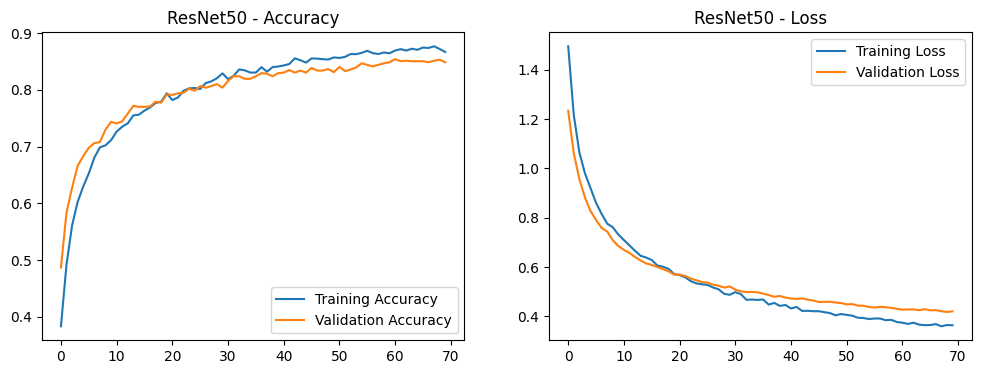

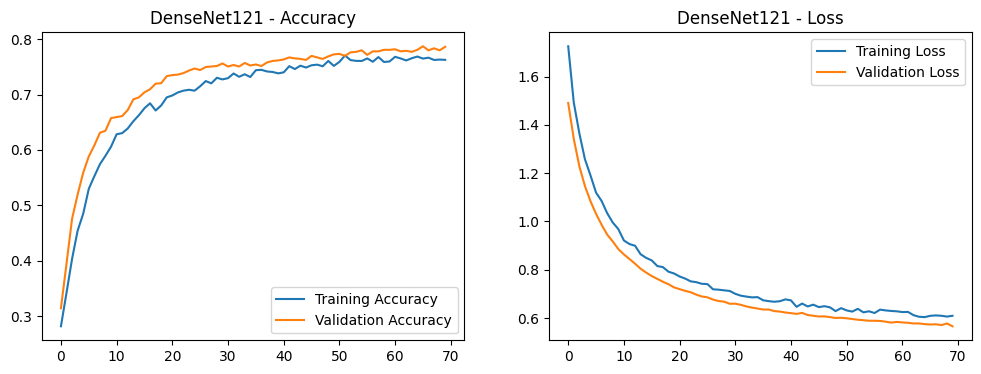

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset',               
    validation_split=0.2,    # 20% of images for validation #
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Class names found in the dataset #
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


# DATASET PREPARATION (Performance optimizations) #

AUTOTUNE = tf.data.AUTOTUNE

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# MODEL BUILDING FUNCTION #

def build_pretrained_model(base_model_name, input_shape=(224, 224, 3), num_classes=3):
    """
    Builds a transfer learning model using a specified pretrained base.
    
    base_model_name: str, name of the base model ('ResNet50', 'DenseNet121', etc.)
    input_shape: tuple, the shape of the input images (height, width, channels)
    num_classes: int, number of output classes
    """
    if base_model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
    elif base_model_name == 'DenseNet121':
        base_model = tf.keras.applications.DenseNet121(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
        preprocess_input = tf.keras.applications.densenet.preprocess_input
    else:
        raise ValueError("Unsupported base model name!")
    
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs, name=base_model_name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# TRAIN AND EVALUATE WITH RESNET50 #

print("\n--- Training with ResNet50 ---")
resnet_model = build_pretrained_model('ResNet50', input_shape=(*IMG_SIZE, 3), num_classes=num_classes)
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70
)


# TRAIN AND EVALUATE WITH DENSENET121 #

print("\n--- Training with DenseNet121 ---")
densenet_model = build_pretrained_model('DenseNet121', input_shape=(*IMG_SIZE, 3), num_classes=num_classes)
history_densenet = densenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70
)


# PLOT TRAINING RESULTS #

def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.show()

plot_history(history_resnet, "ResNet50")
plot_history(history_densenet, "DenseNet121")


In [ ]:
resnet_model.save('tom_jerry_resnet_model.keras') 
densenet_model.save('tom_jerry_densenet_model.keras')


In [144]:
test_image_path = 'test.jpg'

# 1. Load and preprocess the image
new_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=IMG_SIZE)
new_image = tf.keras.preprocessing.image.img_to_array(new_image)
new_image = tf.expand_dims(new_image, 0)

# 2. ResNet50 prediction
resnet_predictions = resnet_model.predict(new_image)
resnet_predicted_class = class_names[tf.argmax(resnet_predictions[0])]
print("ResNet50 predicted class:", resnet_predicted_class)

# 3. DenseNet121 prediction
densenet_predictions = densenet_model.predict(new_image)
densenet_predicted_class = class_names[tf.argmax(densenet_predictions[0])]
print("DenseNet121 predicted class:", densenet_predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
ResNet50 predicted class: tom
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
DenseNet121 predicted class: tom
